# Using Neural Networks for L96 Parameterization: Online Training

## Outline:
In the previous two notebooks we showed how a parameterization can be developed for the L96 setup using neural networks using a methodology known as offline training. In this notebook we dive into an alternative training philosophy known as online training.  

## Online vs offline training

The type of ML training done in the previous couple of notebooks, where we estimate the sub-grid terms explicitly as the terms corresponding to the missing scales from a full simulations, is known as offline training. In this training procedure it is assumed that know exactly how to estimate the effect of the missing scales. However, this might not be true in general. For the L96 case there can be differences in the numerics of the one time scale and two time scale models, which will not be accounted for in the sub-grid terms we estimate from the two time-scale more. In more general simulations, e.g. turbulent flows, a clear scale separation into scales is not available, and it is not obvious what the right way to filter the high resolution simulation might be. Additionally, the parameterization learnt using the offline procedure may turn out to be unstable because numerical stability of the parameterized model was never imposed as a constraint during the traing procedure. 

An alternate way to train machine learning models is called online training. In this procedure, rather than training a model that best fits a pre-defined sub-grid tendency, a model is trained which tries to produce a solution of the parameterized low resolution model ($X^{param-LR}$) that is closest to the high resolution model ($X^{HR}$, where this $X$ has been appropriately downscaled to match the resolution of the low resolution model). For the L96 simulation, this would imply that the parameterized one time-scale model match the evolution of the slow variables in the two-time scale model. 

A corresponding loss function may be defined as:

\begin{equation}
L^{Online} = \frac{1}{T}\int_0^T |X^{param-LR} - X^{HR}|^2 dt
\end{equation}

Contrast this to the loss function offline training:
\begin{equation}
L^{Offline} = |P(X_k^{LR}) - U_k|^2,
\end{equation}
where $P(X)$ is the parameterization of the sub-grid terms (coupling terms) $U$. *Note that in both of the loss functions above appropriate averages over available samples are taken.*

So, let's see how this can be done in practice, and what technical changes we need to make. 

Note: Much of this notebook has been inspired by Pavel Perezhogin's [repo](https://github.com/Pperezhogin/L96-predictability). 

In [1]:
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

In [2]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

In [3]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # You can try this if you have a GPU. However, speed up on GPU is only guaranteed after overhead cost of moving data between CPU and GPU is accounted for. 
device = torch.device('cpu')

## Generate the Ground Truth Dataset from the *Real World* 

Same as the past notebooks, we first generate some instance from the two-time scale (also called our "real world") simulation. 

We initialise the L96 two time-scale model using $K$ (set to 8) values of $X$ and $J$ (set to 32) values of $Y$ for each $X$. The model is run for many timesteps to generate the dataset for training later.

In [4]:
# Setup the two time-scale model
time_steps = 32000
forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=forcing)

In [5]:
# Run the two time-scale model

# The effect of Y on X is `xy_true`
X_true, _, _, _ = W.run(dt, T, store=True, return_coupling=True)

# Change the data type to `float32` in order to avoid doing type conversions later on
X_true = X_true.astype(np.float32)

# Notice that we only output the model trajectory here, as we don't need the coupling terms for training here. 

We now need to set the number of time steps that the training process will use for every sample (how long of a trajectory are we trying to match). 

In [6]:
Tstep_train = 128 

# We split the simulation into ensembles members without any overlap, 
# and each of these will be used as a separate sample.
N_ens = int(time_steps/ Tstep_train)
X_true_ens = np.reshape(X_true[0:N_ens*Tstep_train,:], (N_ens, Tstep_train, 8) )

In [7]:
# Split the data into training and test

# Set the number of time series that will be part of test ensemble. 
test_ens = 32

# Training Data
X_true_train = X_true_ens[0:-test_ens, :, :]  

# Test Data
X_true_test = X_true_ens[-test_ens:, :, :]  

In [8]:
X_true_train.shape, X_true_test.shape

((218, 128, 8), (32, 128, 8))

In [9]:
# Number of sample in each batch
BATCH_SIZE = 32

Notice that in the training and testing datasets defined below the input to the model is the initial condition, and the output that the model will be evaluated against is a time series from the simulation. 

In [10]:
# Training Dataset
# ----------------
nlocal_data_train = Data.TensorDataset(
    torch.from_numpy(X_true_train[:,0,:]), # expected input is an initial condition
    torch.from_numpy(X_true_train) # expected output as a time series
)

nlocal_loader_train = Data.DataLoader(
    dataset=nlocal_data_train, batch_size=BATCH_SIZE, shuffle=False
)

# Test Dataset
# ------------
nlocal_data_test = Data.TensorDataset(
    torch.from_numpy(X_true_test[:,0,:]), 
    torch.from_numpy(X_true_test)
)
nlocal_loader_test = Data.DataLoader(
    dataset=nlocal_data_test, batch_size=BATCH_SIZE, shuffle=False
)

## Create a differentiable 1 time-scale L96 model 

One of the key components needed for online training is a differentiable solver. This can be seen by the presence of $X^{param-LR}$ in the loss function, which indicates that derivatives should be able to pass through a function that not only corresponds to the extra terms that are added, but also produces the full solution.

This relatively to easy to do with modern machine learning frameworks like PyTorch or JAX, as long as the model is simple enough to be rewritten using these frameworks. 

Here we will write a differentiable solver for :
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F.
\end{align}

Notice below that in this case this task was as simple as using the word `torch` instead of `np`, basically swapping out numpy calls with PyTorch calls. 

In [11]:
def L96_eq1_xdot_torch(X, F=20):
    '''
    Compared to older function works on batches,
    i.e. dimension is Nbatch x K (single time step for many batches is input)
    '''
    return torch.roll(X, shifts=1, dims=-1) * (torch.roll(X, shifts=-1, dims=-1) - torch.roll(X, shifts= 2, dims=-1)) - X + F

In [12]:
def RK4(fn, dt, X, *kw):
    """
    Calculate the new state X(n+1) for d/dt X = fn(X,t,...) using the fourth order Runge-Kutta method.
    Args:
        fn     : The function returning the time rate of change of model variables X
        dt     : The time step
        X      : Values of X variables at the current time, t
        kw     : All other arguments that should be passed to fn, i.e. fn(X, t, *kw)
    Returns:
        X at t+dt
    """

    Xdot1 = fn(X, *kw)
    Xdot2 = fn(X + 0.5 * dt * Xdot1, *kw)
    Xdot3 = fn(X + 0.5 * dt * Xdot2, *kw)
    Xdot4 = fn(X + dt * Xdot3, *kw)
    return X + (dt / 6.0) * ((Xdot1 + Xdot4) + 2.0 * (Xdot2 + Xdot3))

## Define a Neural Network for the parameterization

Here we use a neural network architecture that is exactly the same as the non-local architecture that was used in the previous notebooks. 

In [13]:
class FCNN_nonlocal(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [14]:
fcnn_online_network = FCNN_nonlocal().to(device)

## Loss function and optimizer for online training

The target of the loss function in online training is not simply to match the sub-grid fluxes, but instead to also track the solution of the two time-scale model using the single time-scale model. 

The loss function below is where the magic happens. Notice two key elements: (1) the neural network is combined with the numerical solver that produces the tendency at every time step, (2) a time integration is performed over the number some number of time steps. 

In [15]:
def compute_loss(NN, x_in, y_true):
    """
    NN: the neural network that parameterizes the missing terms
    x_in: initial conditions, which are the input. Shape (batch size X K)
    y_true: full solution from the two time scale model. Shape (batch size X Nt X K)
    """
    full_xdot = lambda x: NN(x) +  L96_eq1_xdot_torch(x, F=forcing) # make a function that returns tendency with NN as param.

    y_pred = 0 * y_true # Use this to store the model prediction we make

    y_pred[:,0,:] = x_in # intiailize IC (which is the only input to model).

    for j in range(y_true.shape[1]-1): # loop over time steps

        y_pred[:,j+1,:] = RK4(full_xdot, dt, y_pred[:,j,:].clone()) # time step forward. 

    return ((y_pred-y_true)**2).mean()

Since the only free parameters correspond to the weights of the neural network, they are passed to the optimizer. Notice that even though the loss function is much more complex than the offline training case, the parameters that are being optimized are the same.

In [16]:
# setup optimizer. 

optimizer_fcnn = optim.Adam(fcnn_online_network.parameters(), lr=0.01)

## Training

First we define the helper functions for training, testing and fitting, same as we did in previous notebooks

In [17]:
def train_model(network, criterion, loader, optimizer):
    """Train the network for one epoch"""
    network.train()

    train_loss = 0
    
    for batch_x, batch_y in loader:
        
        
        # Compute the loss (now the predictions are done directly in the loss function).
        loss = criterion(network, batch_x.to(device), batch_y.to(device))
        train_loss += loss.item()

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute the gradients and update the weights
        loss.backward()
        optimizer.step()

    return train_loss / len(loader)

def test_model(network, criterion, loader):
    """Test the network"""
    network.eval()  # Evaluation mode (important when having dropout layers)

    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:

            # Compute the loss
            loss = criterion(network, batch_x.to(device), batch_y.to(device))
            test_loss += loss.item()

        # Get an average loss for the entire dataset
        test_loss /= len(loader)

    return test_loss

def fit_model(network, criterion, optimizer, train_loader, test_loader, n_epochs):
    """Train and validate the network"""
    train_losses, test_losses = [], []
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        train_loss = train_model(network, criterion, train_loader, optimizer)
        test_loss = test_model(network, criterion, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    end_time = time.time()
    print(f"Training completed in {int(end_time - start_time)} seconds.")

    return train_losses, test_losses

In [18]:
# Epochs refer to the number of times we iterate over the entire training data during training.
n_epochs = 100

In [19]:
# Train the model.
train_loss_online, test_loss_online = fit_model(
    fcnn_online_network, compute_loss, optimizer_fcnn, nlocal_loader_train, nlocal_loader_test, n_epochs
)

Training completed in 144 seconds.


Text(0.5, 0, 'Epochs')

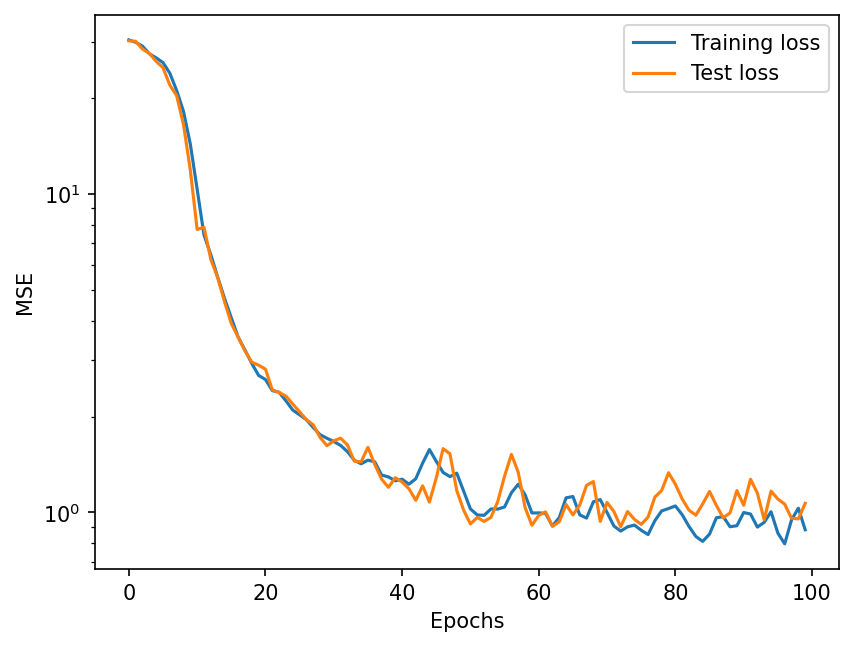

In [20]:
plt.figure(dpi=150)
plt.plot(np.array(train_loss_online), label='Training loss')
plt.plot(np.array(test_loss_online), label='Test loss')
plt.yscale('log')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')

The loss curve above shows that online model is training well, and parameters have been optimized in some sense. Let us check below how this online trained model compares against the offline trained model from the previous notebook. 

## Test in a simulation: Online testing

In [21]:
# Load in the previously trained non-local offline network.
nonlocal_FCNN_weights = torch.load("./networks/non_local_FCNN.pth")

fcnn_offline_network = FCNN_nonlocal()
fcnn_offline_network.load_state_dict(nonlocal_FCNN_weights)

<All keys matched successfully>

In [22]:
# The different GCM classes
# ---------------------------

class GCM_without_parameterization:
    """GCM without parameterization

    Args:
        F: Forcing term
        time_stepping: Time stepping method
    """

    def __init__(self, F, time_stepping=RK4):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time
    
class GCM_network:
    """GCM with neural network parameterization

    Args:
        F: Forcing term
        network: Neural network
        time_stepping: Time stepping method
    """

    def __init__(self, F, network, time_stepping=RK4):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X)
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0))

        # Adding NN parameterization
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy())

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

Now let us pick a random point in the simulation as our initial condition, and compare if there is some drastic difference between offline and online parameterization that can be seen visually. 

In [ ]:
start = 2100
init_conditions = X_true[start, :]
T_test = 10
forcing = 18
dt = 0.01

In [ ]:
gcm_no_param = GCM_without_parameterization(forcing)
X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

In [ ]:
# Evaluate with nonlocal offline FCNN
gcm_nonlocal_offline_net = GCM_network(forcing, fcnn_offline_network)
Xnn_nonlocal_offline, t = gcm_nonlocal_offline_net(
    init_conditions, dt, int(T_test / dt), fcnn_offline_network
)

In [ ]:
# Evaluate with nonlocal offline FCNN
gcm_nonlocal_online_net = GCM_network(forcing, fcnn_online_network)
Xnn_nonlocal_online, t = gcm_nonlocal_online_net(
    init_conditions, dt, int(T_test / dt), fcnn_online_network
)

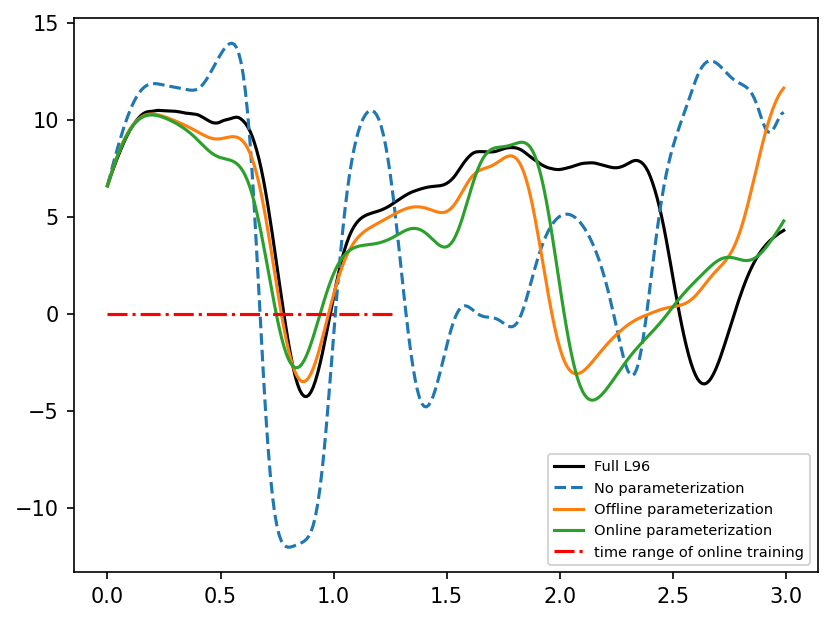

In [ ]:
time_i = 300

plt.figure(dpi=150)
plt.plot(t[:time_i], X_true[start:start+time_i, 4], label="Full L96", color='k')

plt.plot(t[:time_i], X_no_param[:time_i, 4], "--", label="No parameterization")

plt.plot(t[:time_i], Xnn_nonlocal_offline[:time_i, 4], label="Offline parameterization")

plt.plot(t[:time_i], Xnn_nonlocal_online[:time_i, 4], label="Online parameterization")

plt.hlines(0, t[0], t[Tstep_train], label="time range of online training", linestyle='-.', color='r')

plt.legend(loc="lower right", fontsize=7);

The above plot shows that both offline and online trained models perform much better than the simulation without any parameterization. However, it is unclear if there is any signficant gain in the online case. To be more precise, we compare the different cases below over many simulation. 

In [29]:
err_noparam, err_offline, err_online = [], [], []
T_test = 1

for i in range(100):
    init_conditions_i = X_true[i * 10, :]

    # Evaluate with no parameterization
    gcm_no_param = GCM_without_parameterization(forcing)
    X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

    # Evaluate with local FCNN
    gcm_nonlocal_offline_net = GCM_network(forcing, fcnn_offline_network)
    Xnn_nonlocal_offline, t = gcm_nonlocal_offline_net(
                    init_conditions, dt, int(T_test / dt), fcnn_offline_network
                                                    )

    # Evaluate with nonlocal FCNN
    gcm_nonlocal_online_net = GCM_network(forcing, fcnn_online_network)
    Xnn_nonlocal_online, t = gcm_nonlocal_online_net(
                    init_conditions, dt, int(T_test / dt), fcnn_online_network
                                )

    
    err_noparam.append(
        np.sum(np.abs(X_true[i * 10 : i * 10 + T_test * 100 + 1] - X_no_param))
    )

    err_offline.append(
        np.sum(np.abs(X_true[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal_offline))
    )

    err_online.append(
        np.sum(np.abs(X_true[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal_online))
    )


print(f"Sum of errors for no parameterization: {sum(err_noparam):.2f}")
print(f"Sum of errors for offline parameterization: {sum(err_offline):.2f}")
print(f"Sum of errors for online parameterization: {sum(err_online):.2f}")

Sum of errors for no parameterization: 526830.43
Sum of errors for offline parameterization: 432909.61
Sum of errors for online parameterization: 432859.35


This assessment shows that the online parameterization performs about the same as offline parameterzation. However, atleast for the L96 model the gains (if any), which come at the cost of signfiant complexity, are not drastic. 

## Summary

In this notebook we described how online training differs from offline training, and provided an example of how online training can be done for the L96 model. While for the L96 model the online training procedure did not produce significant improvements, the gains for other models may be much greater. If interested, you may look at this [blog post](https://raspstephan.github.io/blog/lorenz-96-is-too-easy/) arguing that L96 might be too simple a test case, which is why different training procedures do not result in very significant differences.

In the next few notebooks we show a few tricks to potentially improve performance of neural networks, how to interpret neural networks, and how physics constraints can be added in their architecture.